# Import 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = fm.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression

# Data Import

- input featrue = 26
- 7일간 data를 하나의 instance화 한다면 -> input matrix 7 x 26 -> ouput matrix 7 x 1 (가격만 출력) 
- 2148 row x 26 columns
- 다변량 시계열(multiivariate time series) 예측 system
- In our cousre DA, design for 단변량 시계열(univariate time series) prediction

In [2]:
path = "./Dataset/"
price_tag = ['건고추가격', '대파가격', '마늘가격', '무가격', '배추가격']
crops_en = ['peppers', 'green_onion', 'garlic', 'radish', 'cabbage']

# is zero
isZero = pd.read_csv(path+"da_data.csv")

# no zero 
noZero = pd.read_csv(path+"da_data_nozero.csv")

# new features 
nf_peppers = pd.read_csv(path+"건고추Model.csv")
nf_green_onion = pd.read_csv(path+"대파Model.csv")
nf_garlic = pd.read_csv(path+"마늘Model.csv")
nf_radish = pd.read_csv(path+"무Model.csv")
nf_cabbage = pd.read_csv(path+"배추Model.csv")

original_data_list = [nf_peppers, nf_green_onion, nf_garlic, nf_radish, nf_cabbage]

In [3]:
X_column_pepper = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '건고추거래량', '건고추생산량', '건고추저장이월량', '건고추수입량', '건고추수입금액',
       '건고추재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_pepper = ['건고추가격']

X_column_green_onion = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '대파거래량', '대파생산량', '대파저장이월량', '대파수입량', '대파수입금액',
       '대파재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_green_onion = ['대파가격']

X_column_garlic = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '마늘거래량', '마늘생산량', '마늘저장이월량', '마늘수입량', '마늘수입금액',
       '마늘재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_garlic = ['마늘가격']

X_column_radish = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '무거래량', '무생산량', '무저장이월량', '무수입량', '무수입금액',
       '무재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_radish = ['무가격']

X_column_cabbage = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '배추거래량', '배추생산량', '배추저장이월량', '배추수입량', '배추수입금액',
       '배추재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_cabbage = ['배추가격']

X_column_list = [X_column_pepper, X_column_green_onion, X_column_garlic, X_column_radish, X_column_cabbage]
y_column_list = [y_column_pepper, y_column_green_onion, y_column_garlic, y_column_radish, y_column_cabbage] # oh...is same thing with p-tag...

In [13]:
def pre_processing(data) :
    scaler = MinMaxScaler()
    scale_cols = data.iloc[:,1:].columns
    
    data.sort_index(ascending=False).reset_index(drop=True)
    
    scaled = scaler.fit_transform(data[scale_cols])
    scaled = pd.DataFrame(scaled)
    scaled.columns = scale_cols
    
    return scaled


def get_data_split(data, X_column, y_column) :
    train_X, test_X, train_y, test_y = train_test_split(
    data[X_column], 
    data[y_column],
    test_size=0.2,
    shuffle=True,   # random split 
    random_state=42) # seed 고정, same sampling 
    
    return train_X, test_X, train_y, test_y

In [14]:
def gridsearchCV (model, parameters, X_train, y_train) :
    grid = GridSearchCV(model, param_grid = parameters, scoring='accuracy', cv=2) # cv is fold num
    grid.fit(X_train, y_train)
    
    print('GridSearchCV 최적 하이퍼 파라미터 :', grid.best_params_)
    print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid.best_score_))
    print('GridSearchCV 최적 하이퍼 파라미터로 학습된 Esimator 반환')
    
    return grid.best_estimator_


def feature_importance(model_xgb) : 
    fig, ax = plt.subplots(figsize=(10,12))
    plot_importance(model_xgb, ax=ax)

In [15]:
# window_size만큼 데이터를 잘라 이어붙여주는 함수
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)


def make_dataset_split(data, feature_cols, label_cols, window_size) :
    print('feature : ', feature_cols, '\nlabel : ', label_cols)
    feature = data[feature_cols]
    label = data[label_cols]
    
    # WINDOW_SIZE(과거 며칠간의 데이터를 기반으로 예측할 것인지)만큼 데이터셋 분리
    feature, label = make_dataset(feature, label, window_size)
    
    X_train, X_test, Y_train, Y_test = train_test_split(feature, label, test_size=0.2)
    print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test
    '''
    hist = model.fit(X_train, Y_train, epochs=100, batch_size=10, validation_split=0.2, callbacks=[early_stop, checkpoint])
    model.load_weights(filename)
    pred = model.predict(X_test)
    graph(pred, Y_test)
    '''

In [16]:
# For Graph! 
def view_original_price(num) :
    plt.subplot(211)
    plt.plot(original_data_list[num][price_tag[num]])
    plt.subplot(212)
    plt.plot(input_data_list[num][price_tag[num]])
    plt.show()
    

def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

# Preproecssing 

input_data_list -> 0:건고추, 1:대파, 2:마늘, 3:무, 4:배추

In [17]:
input_data_list = []
for d in original_data_list : 
    processed = pre_processing(d)
    input_data_list.append(processed)

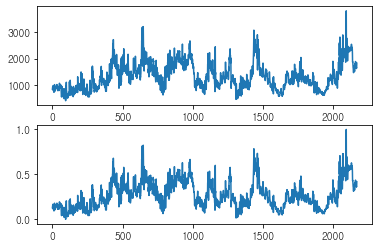

In [18]:
view_original_price(1)

# Modeling 

In [19]:
train_X, test_X, train_y, test_y = make_dataset_split(input_data_list[1], X_column_list[1], y_column_list[1], 7)

feature :  ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속', '최대풍속', '대파거래량', '대파생산량', '대파저장이월량', '대파수입량', '대파수입금액', '대파재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세', '공공서비스', '개인서비스', '근원물가', '생활물가'] 
label :  ['대파가격']
(1729, 7, 26) (1729, 1) (433, 7, 26) (433, 1)


In [20]:
#X_train_see = pd.DataFrame(np.reshape(train_X, (train_X[0], train_X[1])))
#train_X.type()
train_X[0]

array([[0.        , 0.0117096 , 0.25307125, 0.25986079, 0.27654321,
        0.35384615, 0.15151515, 0.25581395, 0.25114155, 0.36464871,
        0.68643034, 0.        , 1.        , 0.94772697, 0.70954716,
        0.4495004 , 0.46569407, 0.43135352, 0.4137931 , 0.29493088,
        0.63636364, 0.44827586, 0.81609195, 0.4       , 0.32      ,
        0.36363636],
       [0.        , 0.00494405, 0.23832924, 0.27842227, 0.22716049,
        0.35384615, 0.22727273, 0.25581395, 0.24429224, 0.3580484 ,
        0.68643034, 0.        , 1.        , 0.94772697, 0.70954716,
        0.44911975, 0.46652015, 0.43200062, 0.4137931 , 0.29493088,
        0.63636364, 0.44827586, 0.81609195, 0.4       , 0.32      ,
        0.36363636],
       [0.0235525 , 0.0273224 , 0.31203931, 0.26218097, 0.36296296,
        0.69230769, 0.25757576, 0.25581395, 0.3652968 , 0.44993869,
        0.68643034, 0.        , 1.        , 0.94772697, 0.70954716,
        0.44823156, 0.46745534, 0.43315615, 0.4137931 , 0.29493088,
      

In [21]:
# hyper parameter tuning 
# 7일간의 28개의 featrure를 받아와서 바로 다음 날의 가격(output_dim=1)을 예측 
WINDOW_SIZE = 7 # sequence
DATA_DIM = 26
OUTPUT_DIM = 1
learning_rate = 0.001
EPOCHS = 1000


In [22]:
# layers.Dense(64, activation='relu'),
def build_model_rnn(lr):
    '''
    parameter -> train_dataset 받았었음 
    model_rnn = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(7,26)),
    layers.Dense(1)])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    '''
    
    # rnn 기본 activation function = tanh 
    # input_shape = None 가능, RNN은 어떤 길이의 타입 step도 처리할 수 있기 때문
    model_rnn =keras.Sequential()
    model_rnn.add(layers.SimpleRNN(units=1, activation='tanh', input_shape=[7,26]))
    model_rnn.add(layer.Dense(1))
    
    # 모델 학습 과정 설정 
    model.compile(loss='mse',
                optimizer=Adam(learning_rate=lr), 
                metrics=['mae', 'mse'])
    
    return model


model_rnn = build_model_rnn(learning_rate)

# 모델 구성 확인 
model_rnn.summary()

NotImplementedError: Cannot convert a symbolic Tensor (simple_rnn_1/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.004254,0.047843,0.004254,0.004787,0.050510,0.004787,995
996,0.004408,0.048721,0.004408,0.004719,0.048826,0.004719,996
997,0.004444,0.049302,0.004444,0.004860,0.049456,0.004860,997
998,0.004331,0.047923,0.004331,0.004848,0.051149,0.004848,998
999,0.004416,0.049105,0.004416,0.004676,0.048831,0.004676,999


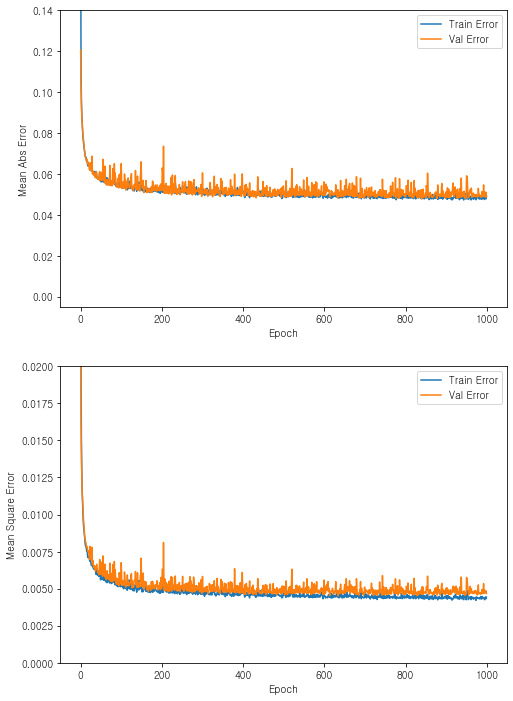

In [21]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize=(8,12))
    
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([-0.005,0.14])
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.ylim([0,0.02])
    plt.legend()
    plt.show()

plot_history(history)

In [23]:
# test set data를 통해 모델이 실전에 투입되었을 때 모델의 성능을 예측
loss, mae, mse = model_rnn.evaluate(test_X, test_y, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f}".format(mae))

14/14 - 0s - loss: 0.3216 - mae: 0.5225 - mse: 0.3216
테스트 세트의 평균 절대 오차:  0.52


In [24]:
pred_rnn = model_rnn.predict(test_X) #.flatten()


In [14]:
error = pred_rnn - test_y
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

ValueError: operands could not be broadcast together with shapes (429,7,1) (429,1) 

In [26]:
df_result = pd.DataFrame(list(zip(test_y, pred_rnn)), columns=['true_y', 'rnn_pred_y'])
df_result 

,true_y,rnn_pred_y
0,[0.7700623882075626],"[[0.08627206], [0.08411063], [0.01790142], [0...."
1,[0.24166989827528845],"[[-0.024897814], [-0.09433138], [-0.05631864],..."
2,[0.770446167800812],"[[-0.06845638], [-0.06398544], [-0.04772553], ..."
3,[0.3110492938513926],"[[0.11817883], [0.056652755], [0.0936659], [0...."
4,[0.37544852850057403],"[[0.02815643], [0.032640398], [0.01801911], [0..."
...,...,...
424,[0.5487347034863701],"[[0.018486664], [0.049323395], [-0.017123923],..."
425,[0.44904765976409133],"[[-0.048763342], [-0.03837119], [-0.08001965],..."
426,[0.45725560323091585],"[[-0.1528171], [-0.029751271], [-0.065164626],..."
427,[0.6577008689209698],"[[0.033073276], [0.12888652], [0.13335738], [0..."


In [16]:
# rmse
mse = mean_squared_error(test_y, pred_rnn)
print("mse:  %f" % mse)

rmse = np.sqrt(mse)
print("rmse: %f" %rmse)

ValueError: Found array with dim 3. Estimator expected <= 2.

ValueError: x and y can be no greater than 2-D, but have shapes (429,) and (429, 7, 1)

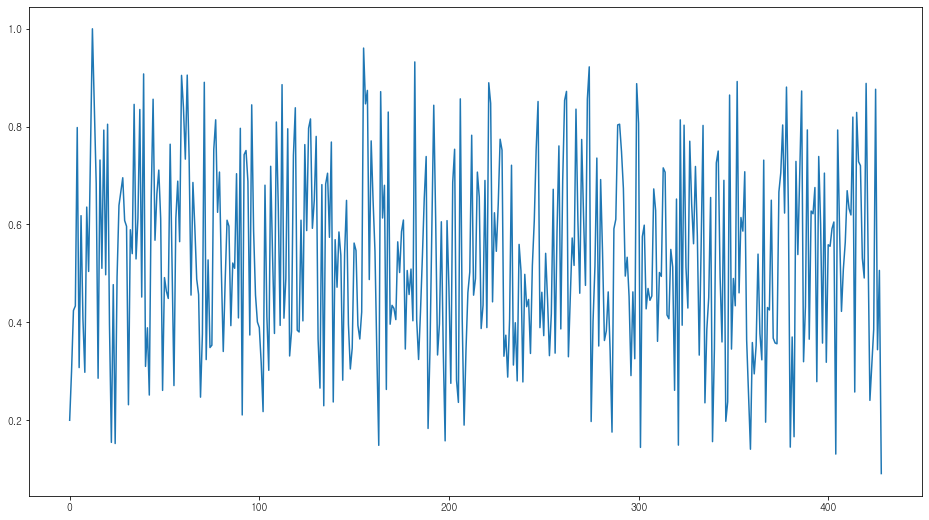

In [17]:
#true_y=test_y.to_numpy()

graph(pred_rnn, test_y)